# **5.3.1. Time series prediction using RNN**#






This example illustrates the implementation of Recurrent Neural Networks (RNN) in PyTorch. Here the RNN model is built for time series prediction using a cosine function with harmonics.  


###**Importing packages,  and loading dataset**###

The first step consists of importing the PyTorch libraries and other necessary packages.

In [1]:
# importing all the necessary packages for performing the experiment
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

###**Setting the parameters for the experiment**###
Let us start with assigning different parameters for the experiment. Here we are starting off with assigning the train-test dataset size followed by model as well as training parameters.

In [2]:
# Parameters of the experiment
train_data_size=250 # size of train data
test_data_size=100 # size of test data
data_size=train_data_size+test_data_size # overall data size
num_epochs = 500 # assiging number of epochs
learning_rate = 0.01 # assigning the learning rate
sigma=0.03 # Noise standard deviation
window_length = 10   # Length of the RNN window
input_size = 1
hidden_size = 100
num_layers = 1
num_classes = 1
batch_size = 64

###**Defining the input to the model**###

The RNN in this example is built to perform one step-ahead prediction of a time series that consists of a harmonic signal with the expression

\begin{equation}
    x[t] = \cos\left[\frac{\pi}{6} t\right]  + \frac{1}{2}\cos\left[\frac{\pi}{3} t\right] + \frac{1}{2}\cos\left[\frac{2\pi}{3} t\right] + g[t]
\end{equation}

for $0 \leq t \leq 200$, and where $g[n]$ is an additive Gaussian noise of independent and identically distributed samples with standard deviation $\sigma=0.1$.

In [3]:
from scipy.signal import butter,filtfilt

def data(type,N):
  if type=='harmonics': # generates the data shown in the above equation
    t = np.pi*torch.linspace(0,data_size-1,data_size)/6
    y_ = (torch.cos(t) + torch.cos(2*t)/2 + torch.cos(4*t)/4)
  elif type == 'low_pass':
    u = np.random.randn(data_size) # generate random data of size = data_size
    b, a = butter(4, 0.1, btype='low', analog=False) # design a 4th order digital butterworth
                                                     # filter with  critical freq = 0.1 and
                                                     # return the filter coefficients

    y_ = np.copy(filtfilt(b, a, u)) # apply the generated filter forward and backward to u
    y_= torch.Tensor(y_) # converting the resulting output to tensor
  y = y_ + sigma*torch.randn(data_size) # add the low pass filter to the randomly generated data
  return y, y_

#y, y_ = data('harmonics',data_size)
y, y_ = data('low_pass',data_size)

###**Visualizing the data**###

Now lets visualize the function and plot the input data.

<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\c'
C:\Users\aswathyr\AppData\Local\Temp\ipykernel_19692\675558854.py:8: SyntaxWarning: invalid escape sequence '\c'
  plt.savefig('Data\cos.pdf')


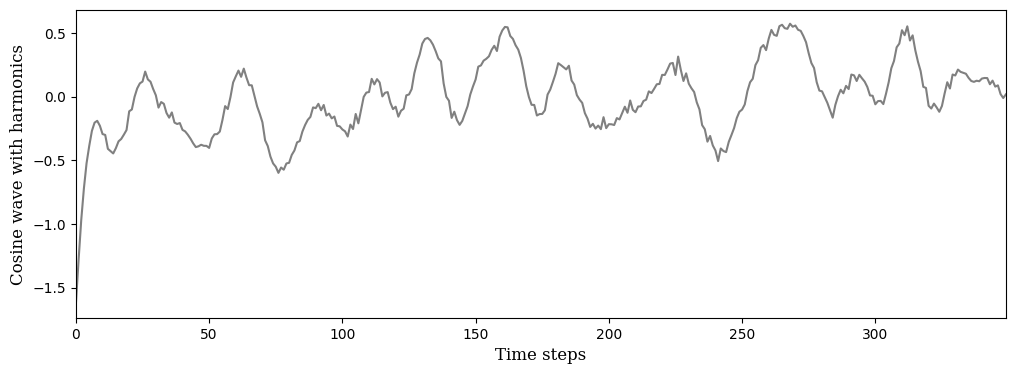

In [4]:
plt.figure(figsize=(12,4))
csfont = {'fontname':'serif'}
plt.xlim(-1,201)
plt.plot(y.numpy(),'Grey')
plt.xlabel('Time steps',fontsize=12,**csfont)
plt.ylabel('Cosine wave with harmonics',fontsize=12,**csfont)
plt.autoscale(axis='x',tight=True)
plt.savefig('Data\cos.pdf')
plt.show()



In this step the data is extracted and divided into training and test. The data is divided into 150 samples for training and 50 for testing. Following this feature normalization is performed using the MinMaxScaler() function and the data is scaled between 0 and 1.

In [5]:
train_data = y[:-test_data_size] # getting the train data
test_data = y[-test_data_size:] # test data
train_data=train_data.reshape(-1, 1) # reshaping the train data
test_data=test_data.reshape(-1, 1) # reshaping test data

sc = MinMaxScaler(feature_range = (0, 1)) # Initializing Minmax scaler
training_data = sc.fit_transform(train_data) # fitting and transforming the train data
testing_data = sc.transform(test_data) # transforming the test data using the fit scaler

###**Define the sliding window**###

Here we define the sliding window for scanning the training and test data. We split the training sequence into overlapping windows while developing the RNN models. For example, if we have a sequence with 16 samples and a window size of 4, we can enter [x1, x2, x3, x4] into the model and compare the forecast to x5. Next we input [x2, x3, x4, x5] into the model and match the forecast to x6 and the process goes on. The sliding window is defined using a function that inputs the data and the sequence length. The output of the function returns the sequence and the corresponding labels.

In [6]:
def sliding_windows(data, window_length):
  '''
  This function implements sliding window
  for making the data to stay in the right format
  Input: data and length of window
  Output: Returns the sequence (x) and the labels (y)
  '''
  x = []
  y = []
  for i in range(len(data)-window_length):
      _x = data[i:(i+window_length)]
      _y = data[i+window_length]
      x.append(_x)
      y.append(_y)
      A=np.shape(x)
  return np.reshape(x,(A[0], A[1], A[2])), y

x, y = sliding_windows(training_data, window_length) # converting training data into training sequence and labels
x1, y1 = sliding_windows(testing_data, window_length) # converting testing data into testing sequence and labels

 # converting the train and test sequenes to tensors
trainX = Variable(torch.Tensor(np.array(x)))
trainY = Variable(torch.Tensor(np.array(y)))
testX = Variable(torch.Tensor(np.array(x1)))
testY = Variable(torch.Tensor(np.array(y1)))

# converting the train dataset and test dataset into list of tensors
train_dataset = TensorDataset(trainX, trainY)
test_dataset  = TensorDataset(testX, testY)


train_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size)
print(trainX.shape,trainY.shape)
print(testX.shape,testY.shape)


torch.Size([240, 10, 1]) torch.Size([240, 1])
torch.Size([90, 10, 1]) torch.Size([90, 1])


###**RNN model architecture**###

The RNN architecture is defined as a class that consists of 1 RNN layer and a fully-connected layer.

In [7]:
class RNN(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()

        self.num_classes = num_classes # the number of output time steps.
        self.num_layers = num_layers #the number of recurrent layers.
        self.input_size = input_size # the number of expected features in the input.
        self.hidden_size = hidden_size # the number of features in the hidden state h.

        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, nonlinearity='tanh')
        #If batch_first is True, then the input and output tensors are provided as (batch, seq, feature).

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) # initialize hidden state.
        h_x, h_out = self.rnn(x, h_0)
        #h_out = h_x.view(-1, self.hidden_size)
        h_out1=h_x[:, -1, :] # reshape the output into (batch_size*seq_length, hidden_size).
        out = self.fc(h_out1)

        return out

###**Training of the RNN**###

In the training, we construct a for loop for performing the gradient descent and backpropagation. In the first step we compute the forward pass through the network by applying the model to the training examples. Next the loss is calculated based on the defined loss function, which compares the model output to the actual training labels. The .backward() function is used to backpropagate the derivative of the loss with respect to the model parameters through the network. After setting the current parameter gradients to zero with .zero_grad(), we update the model parameters by subtracting the gradient times the learning rate. This is done with the optimizer, using optimizer.step(). Here we use the Adam optimizer and mean square error loss for optimization.

In [8]:
rnn = RNN(num_classes, input_size, hidden_size, num_layers)
print(rnn)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
loss_curve=[]
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    loss_total = 0
    outputs = rnn(images)
    optimizer.zero_grad()
    loss = criterion(outputs,labels)
    loss_total += loss.item()
    loss.backward()

    optimizer.step()
  loss_curve.append(loss_total)
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

RNN(
  (rnn): RNN(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)
Epoch: 0, loss: 0.03615
Epoch: 100, loss: 0.00187
Epoch: 200, loss: 0.00059
Epoch: 300, loss: 0.00059
Epoch: 400, loss: 0.00059


**Plotting the loss curve for the training data**

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
C:\Users\aswathyr\AppData\Local\Temp\ipykernel_19692\3359597680.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.savefig('Data\loss_rnn.pdf')


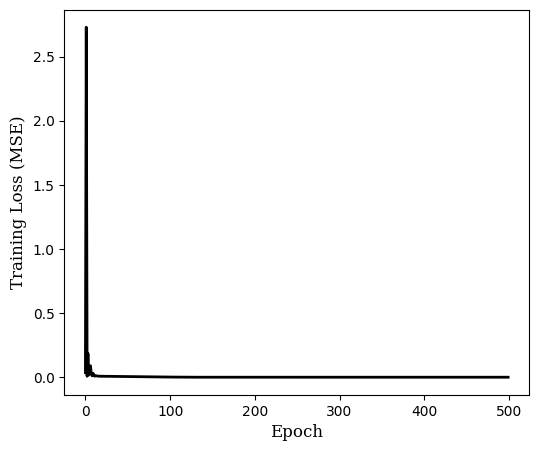

In [9]:
plt.figure(figsize=(6,5))
csfont = {'fontname':'serif'}
plt.plot(loss_curve, lw=2,color='k')
plt.xlabel("Epoch",fontsize=12,**csfont)
plt.ylabel("Training Loss (MSE)",fontsize=12,**csfont)
plt.savefig('Data\loss_rnn.pdf')
plt.show()

**Predictions on the test data**

<>:19: SyntaxWarning: invalid escape sequence '\O'
<>:19: SyntaxWarning: invalid escape sequence '\O'
C:\Users\aswathyr\AppData\Local\Temp\ipykernel_19692\2408504706.py:19: SyntaxWarning: invalid escape sequence '\O'
  plt.savefig('Data\Output_rnn.pdf')


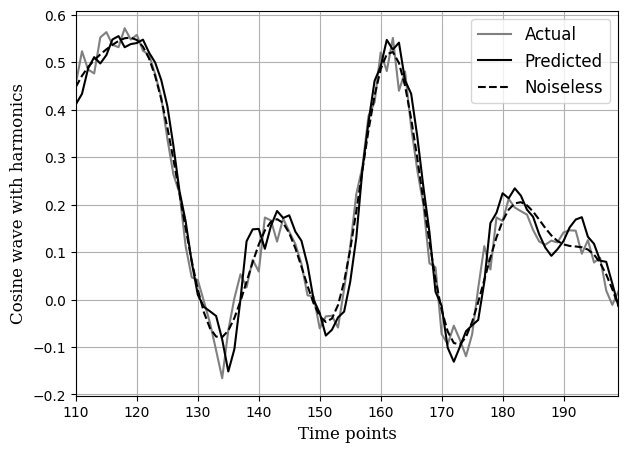

In [10]:
rnn.eval()
test_predict = rnn(testX)
data_predict = test_predict.data.numpy()
dataY_plot = testY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)
plt.figure(figsize=(7,5))
x = np.arange(200-dataY_plot.size,200, 1)
csfont = {'fontname':'serif'}
plt.plot(x,dataY_plot,color='Grey',label='Actual')
plt.plot(x,data_predict,color='Black',label='Predicted')
plt.plot(x, y_[-test_predict.size()[0]:], color='Black',linestyle='dashed',label='Noiseless')
plt.xlabel('Time points',fontsize=12,**csfont)
plt.ylabel('Cosine wave with harmonics',fontsize=12,**csfont)
plt.autoscale(axis='x',tight=True)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('Data\Output_rnn.pdf')
plt.show()
